In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
# read file
stock_path = "C:/Users/acer/Desktop/LAB/lab2.csv"
stock_df = pd.read_csv(stock_path)

In [3]:
stock_df = stock_df[["Date","Close"]]

In [4]:
scaler= MinMaxScaler(feature_range = (0,1))

In [5]:
minmax_df = scaler.fit_transform(stock_df[["Close"]].values)

In [6]:
print(minmax_df)

[[0.1465188 ]
 [0.12814316]
 [0.13684748]
 ...
 [0.39703834]
 [0.45126814]
 [0.47148938]]


In [7]:
minmax_df = pd.DataFrame(minmax_df,columns = ["Close"])

In [8]:
minmax_df["Date"] = stock_df["Date"].values

In [9]:
minmax_df[:10]

,Close,Date
0,0.146519,2010/1/20
1,0.128143,2010/1/21
2,0.136847,2010/1/22
3,0.117021,2010/1/25
4,0.098646,2010/1/26
5,0.098646,2010/1/27
6,0.115571,2010/1/28
7,0.121857,2010/1/29
8,0.119439,2010/2/1
9,0.104448,2010/2/2


In [10]:
minmax_df = minmax_df[1:]

In [14]:
#hy parameter
torch.manual_seed(1)
EPOCH = 100
BATCH_SIZE = 32
TIME_STEP = 30
INPUT_SIZE = 1
LR = 0.01

In [15]:
len(minmax_df)

2438

In [24]:
# declear training features data
features = []
for i in range(TIME_STEP,len(minmax_df)-6):
    x = minmax_df[i-TIME_STEP:i][["Close"]].values
    features.append(x.tolist())
features = torch.FloatTensor(features)
print("size of feature: ",features.size())

# declear trainging labels data
labels = []
for i in range(TIME_STEP,len(minmax_df)-6):
    x = minmax_df[i:i+7]["Close"]
    labels.append(x.tolist())
labels = torch.FloatTensor(labels)
print("size of label: ",labels.size())

size of feature:  torch.Size([2402, 30, 1])
size of label:  torch.Size([2402, 7])


In [28]:
train_features = features[:2200]
train_labels = labels[:2200]
test_features = features[2200:]
test_labels = labels[2200:]

In [29]:

#Mini-Batch

torch_dataset = Data.TensorDataset(train_features,train_labels)
train_loader = Data.DataLoader(
    dataset = torch_dataset,
    batch_size = BATCH_SIZE,
    num_workers = 2,
    shuffle=True,
)

In [30]:

#define NN architecture


class RNN(torch.nn.Module):   
    def __init__(self):
        super(RNN,self).__init__()
        # define lstm layer
        self.lstm = torch.nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=128,         
            num_layers=1,
            batch_first=True, 
        )
        self.lstm2 = torch.nn.LSTM(
            input_size=128,
            hidden_size=64,         
            num_layers=1,
            batch_first=True, 
        )
        # dropout layer
        self.Relu =  torch.nn.ReLU()
        self.hidden1 = torch.nn.Linear(64,32)
        self.out = torch.nn.Linear(32,7)
        
    def forward(self,x):
        lstm_out,(h_n,h_c) = self.lstm(x,None)
        lstm_out = self.Relu(lstm_out)
        lstm_out,_ = self.lstm2(lstm_out,None)
        lstm_out = self.Relu(lstm_out[:,-1,:])
        # only need last output of lstm layer
        h1_out = self.hidden1(lstm_out)
        h1_out = self.Relu(h1_out)
        out = self.out(h1_out)
        
        return out


In [31]:
model = RNN()
print(model)

RNN(
  (lstm): LSTM(1, 128, batch_first=True)
  (lstm2): LSTM(128, 64, batch_first=True)
  (Relu): ReLU()
  (hidden1): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=7, bias=True)
)


In [32]:
# define optimizer and loss function 
optimizer = torch.optim.Adam(model.parameters(), lr=LR,weight_decay=0.00015)
# adject learning rate . when loss don't fall , lr = lr * factor  , min lr = 0.0001
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.98,min_lr=0.0001)
# crossentroy loss 
loss_func = torch.nn.MSELoss()

In [33]:
'''
Training 
'''
LOSS = []
TEST_LOSS = []
TEST_ACC = []
TRAIN_ACC = []
for epoch in range(EPOCH):
    loss_total = 0
    for step,(inputs,targets) in enumerate(train_loader):
        inputs = inputs.view(-1,TIME_STEP,INPUT_SIZE)
        # start trainnig 
        output = model(inputs)
        # calculate loss  (cross entroy)
        loss = loss_func(output,targets)
        # clear the gradients of all optimized variables(from last training)
        optimizer.zero_grad()
        # back propagation
        loss.backward()
        optimizer.step()
        # sum of loss
        loss_total = loss_total + loss
        
        # print training info every 30 steps
        if((step+1) %30 == 0):
            # average of loss in 30 steps
            avg = loss_total / 30
            LOSS.append(avg.tolist())
            
            # calculate the accuracy of training 
            pred_train_y = torch.max(output, 1)[1].data.numpy()
            #train_accuracy = float((pred_train_y == targets.numpy()).astype(int).sum()) / float(targets.numpy().size)
            #TRAIN_ACC.append(train_accuracy)
            
            # calculate the accuracy of using testing data as inputs
            test_output = model(test_features.view(-1,TIME_STEP,INPUT_SIZE))
            pred_test_y = torch.max(test_output, 1)[1].data.numpy()
            #test_accuracy = float((pred_test_y == test_labels.numpy()).astype(int).sum()) / float(test_labels.numpy().size)
            #TEST_ACC.append(test_accuracy)
            test_loss = loss_func(test_output,test_labels)
            TEST_LOSS.append(test_loss.tolist())
            # print the epoch , steps , average loss , accuracy 
            print("Epoch: %4d|steps: %4d|Train Avg Loss: %.4f |Test Loss: %.4f|lr = %.5f"
                  %(epoch+1,step+1,avg,test_loss,optimizer.param_groups[0]['lr']))
            
            # inital variable
            loss_total = 0
    # updata learning rate
    scheduler.step(loss)
        


Epoch:    1|steps:   30|Train Avg Loss: 0.1030 |Test Loss: 0.0051|lr = 0.01000
Epoch:    1|steps:   60|Train Avg Loss: 0.0786 |Test Loss: 0.0035|lr = 0.01000
Epoch:    2|steps:   30|Train Avg Loss: 0.0304 |Test Loss: 0.0050|lr = 0.01000
Epoch:    2|steps:   60|Train Avg Loss: 0.0045 |Test Loss: 0.0007|lr = 0.01000
Epoch:    3|steps:   30|Train Avg Loss: 0.0023 |Test Loss: 0.0010|lr = 0.01000
Epoch:    3|steps:   60|Train Avg Loss: 0.0020 |Test Loss: 0.0019|lr = 0.01000
Epoch:    4|steps:   30|Train Avg Loss: 0.0019 |Test Loss: 0.0013|lr = 0.01000
Epoch:    4|steps:   60|Train Avg Loss: 0.0022 |Test Loss: 0.0023|lr = 0.01000
Epoch:    5|steps:   30|Train Avg Loss: 0.0022 |Test Loss: 0.0009|lr = 0.01000
Epoch:    5|steps:   60|Train Avg Loss: 0.0018 |Test Loss: 0.0006|lr = 0.01000
Epoch:    6|steps:   30|Train Avg Loss: 0.0021 |Test Loss: 0.0007|lr = 0.01000
Epoch:    6|steps:   60|Train Avg Loss: 0.0038 |Test Loss: 0.0009|lr = 0.01000
Epoch:    7|steps:   30|Train Avg Loss: 0.0029 |Test

Epoch:   53|steps:   30|Train Avg Loss: 0.0014 |Test Loss: 0.0007|lr = 0.00941
Epoch:   53|steps:   60|Train Avg Loss: 0.0014 |Test Loss: 0.0006|lr = 0.00941
Epoch:   54|steps:   30|Train Avg Loss: 0.0015 |Test Loss: 0.0014|lr = 0.00941
Epoch:   54|steps:   60|Train Avg Loss: 0.0012 |Test Loss: 0.0006|lr = 0.00941
Epoch:   55|steps:   30|Train Avg Loss: 0.0016 |Test Loss: 0.0006|lr = 0.00941
Epoch:   55|steps:   60|Train Avg Loss: 0.0013 |Test Loss: 0.0007|lr = 0.00941
Epoch:   56|steps:   30|Train Avg Loss: 0.0013 |Test Loss: 0.0006|lr = 0.00941
Epoch:   56|steps:   60|Train Avg Loss: 0.0013 |Test Loss: 0.0009|lr = 0.00941
Epoch:   57|steps:   30|Train Avg Loss: 0.0015 |Test Loss: 0.0014|lr = 0.00941
Epoch:   57|steps:   60|Train Avg Loss: 0.0015 |Test Loss: 0.0007|lr = 0.00941
Epoch:   58|steps:   30|Train Avg Loss: 0.0012 |Test Loss: 0.0007|lr = 0.00941
Epoch:   58|steps:   60|Train Avg Loss: 0.0015 |Test Loss: 0.0006|lr = 0.00941
Epoch:   59|steps:   30|Train Avg Loss: 0.0013 |Test

In [100]:
predict_price =train_features[len(train_features)-1].numpy().tolist()

In [101]:
predict_price

[[0.4365617334842682],
 [0.4531064033508301],
 [0.4577021598815918],
 [0.4816000163555145],
 [0.4907914996147156],
 [0.4834383428096771],
 [0.4788426160812378],
 [0.48987236618995667],
 [0.48895323276519775],
 [0.47057026624679565],
 [0.46321702003479004],
 [0.46413615345954895],
 [0.44942978024482727],
 [0.455863893032074],
 [0.44851067662239075],
 [0.4586212933063507],
 [0.46413615345954895],
 [0.4549446702003479],
 [0.455863893032074],
 [0.46321702003479004],
 [0.4760851263999939],
 [0.46873190999031067],
 [0.48251914978027344],
 [0.48527660965919495],
 [0.48527660965919495],
 [0.4907914996147156],
 [0.5542128086090088],
 [0.5376680493354797],
 [0.5413447022438049],
 [0.5486978888511658]]

In [102]:
for i in range(0,28):
    pred_input = torch.FloatTensor(np.array(predict_price[0+i*7:30+i*7]))
    print(i*7+0 , 30+i*7)
    pred_output = model(pred_input.view(-1,TIME_STEP,INPUT_SIZE))
    pred_output = pred_output.view(-1,1).detach().numpy()
    predict_price.extend(pred_output.tolist())
    print(len(predict_price))
    print("success")
    

0 30
37
success
7 37
44
success
14 44
51
success
21 51
58
success
28 58
65
success
35 65
72
success
42 72
79
success
49 79
86
success
56 86
93
success
63 93
100
success
70 100
107
success
77 107
114
success
84 114
121
success
91 121
128
success
98 128
135
success
105 135
142
success
112 142
149
success
119 149
156
success
126 156
163
success
133 163
170
success
140 170
177
success
147 177
184
success
154 184
191
success
161 191
198
success
168 198
205
success
175 205
212
success
182 212
219
success
189 219
226
success


In [103]:
len(predict_price)

226

In [104]:
predict_price = np.array(predict_price[30:])
predict_price = predict_price.reshape(-1,1)
predict_price =  scaler.inverse_transform(predict_price)

In [114]:
y1 = test_labels[:196].numpy().reshape(-1,1)
y1 = scaler.inverse_transform(y1)
len(test_labels)

202

ValueError: x and y must have same first dimension, but have shapes (196,) and (1372, 1)

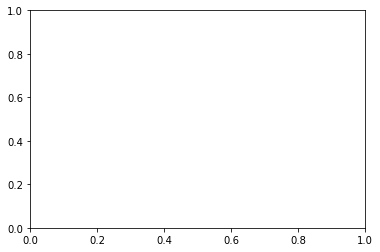

In [111]:
x = np.linspace(1,196,196)
y2 = predict_price
plt.plot(x,y1)
plt.plot(x,y2)
plt.show()